In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 07/07/2021 23:00:48


In [2]:
# open the data
m1_dir = '/home/jhen/XWCL/code/MagAOX/data/wfemap/'
m1_loc = m1_dir+'ClayM1_0mask_meters_new.fits'
m1 = fits.open(m1_loc)[0]
m1_dx = (m1.header['puplscal'] * u.m)#.to(u.mm)
m1_data = (m1.data * u.m)#.to(u.nm)
m1_diam = 6.5 * u.m

Text(0.5, 1.0, 'Magellan Clay M1 surface (masked)')

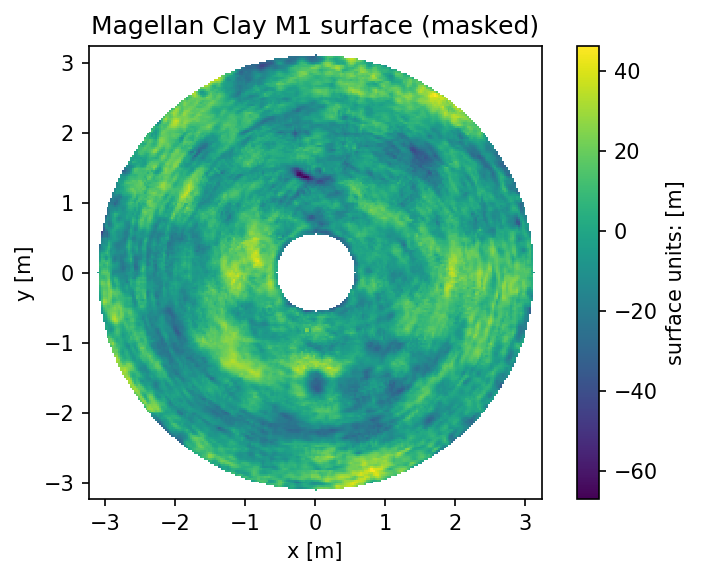

In [3]:
# Build the binary mask to clean up edges for PSD
cen = int(np.shape(m1_data)[0]/2)
yy, xx = np.mgrid[-cen:cen+1, -cen:cen+1]
r_in = 20
r_out = 112
circ_in = xx**2 + yy**2 <= r_in**2
circ_out = xx**2 + yy**2 <= r_out**2
m1_mask = circ_out ^ circ_in

xy = xx[0]*m1_dx.to(u.m)
xy_low = np.amin(xy.value)
xy_high = np.amax(xy.value)
plt.figure(dpi=150)
plt.imshow(dfx.sn_map(surface=(m1_data.to(u.nm)).value, mask=m1_mask), origin='lower',
           extent=[xy_low, xy_high, xy_low, xy_high])
plt.xlabel('x [{0}]'.format(xy.unit))
plt.ylabel('y [{0}]'.format(xy.unit))
plt.colorbar().set_label('surface units: [{0}]'.format(m1_data.unit))
plt.title('Magellan Clay M1 surface (masked)')

In [4]:
%%time
# calculating the PSD uses the multivariate lomb-scargle due to center hole
m1_psd, m1_lspsd_parms = psd.mvls_psd(data=m1_data, mask=m1_mask, dx=m1_dx,
                                  k_side = np.shape(m1_data)[0], print_update=True,
                                  write_psd=False, psd_name='lspsd_m1')

Scargling in progress, starting time = 23:00:49
0 of 54289 complete (0.00%), time = 23:00:49
10000 of 54289 complete (18.42%), time = 23:00:57
20000 of 54289 complete (36.84%), time = 23:01:06
30000 of 54289 complete (55.26%), time = 23:01:14
40000 of 54289 complete (73.68%), time = 23:01:22
50000 of 54289 complete (92.10%), time = 23:01:31
Scargling and PSD completed, ending time = 23:01:34
CPU times: user 1min 30s, sys: 908 ms, total: 1min 30s
Wall time: 45.5 s


In [5]:
%%time
# build the radial frequency range
m1_dk = m1_lspsd_parms['dk'].to(1/u.m)
m1_psd = m1_psd.to(u.m**2 * u.nm**2)

# calculate the radial PSD data
k_radial, psd_radial = psd.do_psd_radial(psd_data=m1_psd, 
                                         delta_k=m1_dk, 
                                         kmin = 1/m1_diam)

CPU times: user 87.3 ms, sys: 4.04 ms, total: 91.4 ms
Wall time: 45.6 ms


Text(0, 0.5, 'Power Spectrum [$nm^{2}$$m^{2}$]')

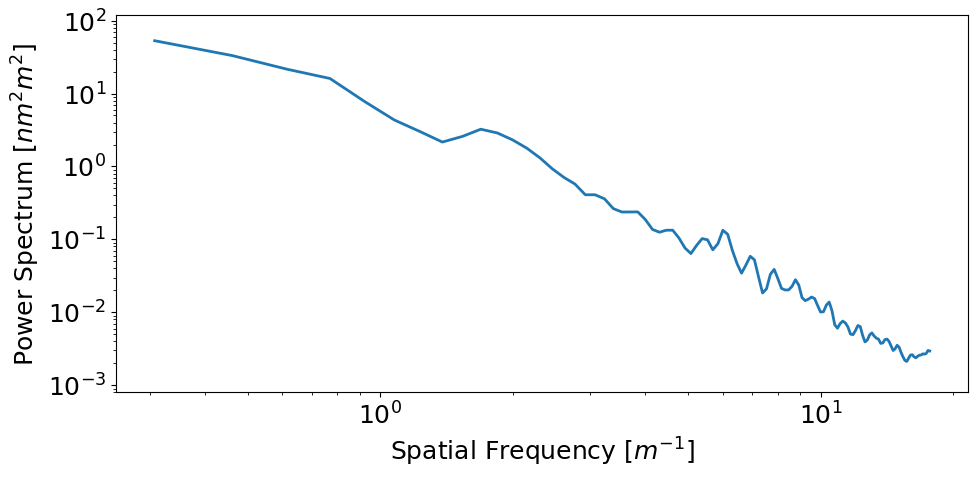

In [7]:
ylim = [1e2, 1e-3]
xlim = [1e-1, 1e2]

matplotlib.rcParams["font.size"]=18
plt.figure(figsize=[11,5], dpi=100)
plt.loglog(k_radial, psd_radial, linewidth=2)
plt.ylim(top=ylim[0]*1.2, bottom=ylim[1]*0.8)
#plt.xlim(left=xlim[0]*0.8, right=xlim[1]*1.2)
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))

In [9]:
# save the radial PSD content as a FITS table file
# assemble the table HDU for the radial PSD data
c0 = fits.Column(name='kval', array=k_radial.value, format='D')
c1 = fits.Column(name='psd_m1', array=psd_radial.value, format='D')
psd_hdu = fits.BinTableHDU.from_columns([c0, c1])

# make the primary header file
hdr = fits.Header()
hdr.set('psd_unit', str(m1_psd.unit),
        'PSD units')
hdr.set('k_unit', str(k_radial.unit),
        'spatial frequency units')
hdr.set('psd_type', 'mvls',
        'psd calculation type: FFT or multivariate lomb-scargle')
hdr.set('delta_k', m1_dk.value, 
        'full psd spatial frequency resolution [{0}]'.format(str(m1_dk.unit)))
k_min = 1/m1_diam
k_max = 1/(2*m1_dx)
hdr.set('kmin', k_min.value,
        'minimum spatial frequency limit [{0}]'.format(str(k_min.unit)))
hdr.set('kmax', k_max.value,
        'maximum spatial frequency limit [{0}]'.format(str(k_max.unit)))
hdr.set('ringsize', 3,
        'annular size for radial PSD averaging [pixel]')
hdr.set('latres', m1_dx.value,
        'surface measurement spatial resolution [{0}]'.format(str(m1_dx.unit)))
hdr.set('diam', 6.5,
        'surface diameter [m]')
hdr['comment'] = 'Table 1 will be radial PSD values, see header card'
empty_primary = fits.PrimaryHDU(header=hdr)

# now save the fits file
hdul = fits.HDUList([empty_primary, psd_hdu])
hdul.writeto('radial/psd_m1.fits', overwrite=True)

Text(0.5, 1.0, 'Magellan Clay M1 PSD with Lomb-Scargle')

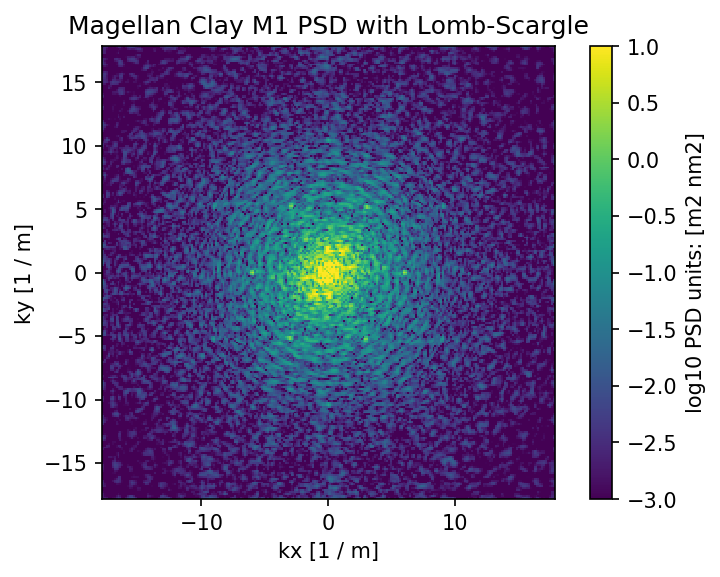

In [10]:
# for plotting purposes
kcen = int(m1_psd.shape[0]/2)
kxy = np.linspace(-kcen, kcen, m1_psd.shape[0]) * m1_dk
radial_freq = kxy[kcen:m1_psd.shape[0]].value

kxy_low = np.amin(kxy.value)
kxy_high = np.amax(kxy.value)
matplotlib.rcParams["font.size"]=10
plt.figure(dpi=150)
plt.imshow(np.log10(m1_psd.value), origin='lower',
           extent=[kxy_low, kxy_high, kxy_low, kxy_high])
plt.xlabel('kx [{0}]'.format(kxy.unit))
plt.ylabel('ky [{0}]'.format(kxy.unit))
plt.clim(vmin=-3, vmax=1)
plt.colorbar().set_label('log10 PSD units: [{0}]'.format(m1_psd.unit))
plt.title('Magellan Clay M1 PSD with Lomb-Scargle')